In [7]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import time


In [8]:
class TreasureHunterSARSA:
    """ 
    A Treasure Hunter that learns using SARSA algorithm! 
    The agent starts at the bottom-left and must find the treasure  
    while avoiding dangerous traps in a grid world. 
    """ 
    def __init__(self, grid_size = 5, alpha = 0.1, gamma = 0.9, epsilon = 0.1, min_epsilon=0.01, decay_rate=0.001, c=2):
        """ 
        Initialize our Treasure Hunter 
        Args: 
        grid_size: Size of the grid world (grid_size x grid_size) 
        alpha: Learning rate (how fast we learn from mistakes) 
        gamma: Discount factor (how much we care about future rewards) 
        epsilon: Exploration rate (how often we try random actions) 
        """
        
        self.Q = {}  # Q-values
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.c = c  # UCB exploration constant
        self.action_counts = {}  # store number of times each action taken
        
        self.size = grid_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        #actions {0->up, 1->right, 2->down, 3->left}
        self.actions = ['UP','RIGHT','DOWN', 'LEFT']
        self.action_effects = [(-1, 0), (0,1), (1,0), (0,-1)]
        
        #initialize q-table :
        self.Q = defaultdict(lambda: np.zeros(4))
        
        #Game setup
        self.start_pos = (grid_size-1, 0) #bottom-left corner
        self.treasure_pos = (0, grid_size-1) #top-right corner
        self.traps = [(1,1), (2,3), (3,2)] #Dangerous traps!

        #keep track of learning progress
        self.episode_rewards = []
        self.episode_steps = []  
        
    #converting position tuple to string key for q-table
    def get_state_key(self, pos):
        return f"{pos[0]}, {pos[1]}"
    
    #checking if position is within grid boundaries
    def is_valid_position(self, pos):
        row, col = pos
        return row>=0 and row<self.size and col>=0 and col<self.size 
    
    #this function gives reward for each action
    def get_reward(self, pos):
        if pos == self.treasure_pos:
            #Found the treasure
            return 100 
        elif pos in self.traps:
            #oops hit in a trap
            return -50
        else:
            #same penalty for each step(encourages efficiency)
            return -1
    
    #move the agent and return new position and reward
    def take_action(self, pos, action):
        row, col = pos
        d_row, d_col = self.action_effects[action]
        new_pos = (row + d_row, col + d_col)
        
        #if move goes outside grid, then stay in current position
        if not self.is_valid_position(new_pos):
            new_pos = pos
        
        reward = self.get_reward(new_pos)
        return new_pos, reward

    #epsilon greedy policy: sometimes explore, sometime exploit
    def choose_action_epsilon_greedy(self, state_key, epsilon = None):
        #if epsilon is none use default epsilon
        if epsilon is None:
            epsilon = self.epsilon
        
        if np.random.random() < epsilon:
            #explore: random action
            return np.random.choice(4)
        else:
            #exploit: choosing the best known action
            return np.argmax(self.Q[state_key])
        
        
    """
    Boltzmann: this one is another action selection policy, but instead of ε-greedy (random vs. best), it uses Boltzmann / Softmax exploration
    """    
    def choose_action_boltzmann(self, start_key, temperature = 1.0):
        #Boltzman policy: probabilistic action selection
        q_values = self.Q[start_key]
        exp_values = np.exp((q_values - np.max(q_values))/ temperature)
        probabilites = exp_values / np.sum(exp_values)
        return np.random.choice(4, p=probabilites)

    #Always choose best action (no exploration)
    def choose_action_greedy(self, state_key):
        return np.argmax(self.Q[state_key])
    
    def get_Q(self, state_key):
        if state_key not in self.Q:
            self.Q[state_key] = np.zeros(4)              # initialize 4 actions with value 0
            self.action_counts[state_key] = np.zeros(4)  # also track counts for UCB
        return self.Q[state_key]
    
    #Two policy is enforced newly
    #Decaying ε-greedy ---
    def choose_action_decay_epsilon(self, state_key, episode=10):
        self.min_epsilon = 0.01 
        self.decay_rate = 0.001 
        epsilon = max(self.min_epsilon, self.epsilon * np.exp(-self.decay_rate * episode))
        if np.random.rand() < epsilon:
            return np.random.choice(4)  # explore
        return np.argmax(self.get_Q(state_key))  # exploit

    #Upper Confidence Bound (UCB) ---
    def choose_action_ucb(self, state_key, t=1):
        q_values = self.get_Q(state_key)
        counts = self.action_counts[state_key] + 1e-5  # avoid division by zero
        ucb_values = q_values + self.c * np.sqrt(np.log(t+1) / counts)
        action = np.argmax(ucb_values)
        self.action_counts[state_key][action] += 1
        return action
    
    
    #action selection based on choosen policy
    def choose_action(self, state_key, policy='epsilon_greedy'):
        if policy == 'epsilon_greedy':
            return self.choose_action_epsilon_greedy(state_key)
        elif policy == 'boltzmann':
            return self.choose_action_boltzmann(state_key)
        elif policy == 'greedy':
            return self.choose_action_greedy(state_key)
        elif policy == "decay_epsilon":
            return self.choose_action_decay_epsilon(state_key)
        elif policy == "ucb":
            return self.choose_action_ucb(state_key)
        else:
            raise ValueError(f"Unknown policy: {policy}")
    
    
    
    """ 
    Run one complete episode using SARSA algorithm 
    Returns: 
        total_reward: Total reward collected in this episode 
        steps: Number of steps taken 
        path: List of positions visited 
    """ 
    def run_episode(self, policy='epsilon_greedy', max_steps = 100):
        #start at the beginning
        current_pos = self.start_pos
        current_state_key = self.get_state_key(current_pos)
        current_action = self.choose_action(current_state_key, policy)
        
        total_reward = 0
        steps = 0
        path = [current_pos]

        #keep moving until we reach treasure, trap or max_steps
        while steps < max_steps:
            #take the action
            next_pos, reward = self.take_action(current_pos, current_action)
            next_state_key = self.get_state_key(next_pos)
            
            #choose the next action using the same policy
            next_action = self.choose_action(next_state_key, policy)
            
            #sarsa updateL: learn from this experience
            current_q = self.Q[current_state_key][current_action]
            next_q = self.Q[next_state_key][next_action]
            
            #the sarsa magic happen here
            self.Q[current_state_key][current_action] += self.alpha * (reward + self.gamma * next_q - current_q)
            
            #update tracking variables
            total_reward += reward
            steps += 1
            path.append(next_pos)

            #check if episode is over
            if next_pos == self.treasure_pos or next_pos in self.traps:
                break
        
            #move to next state and action
            current_pos = next_pos
            current_state_key = next_state_key
            current_action = next_action
        
        return total_reward, steps, path


    #train the agent for multiple episodes
    def train(self, episodes = 1000, policy='epsilon_greedy', verbose=True):
        print(f"Training treasure hunter with {policy} policy...")
        print(f"Running {episodes} episodes..\n")
        
        self.episode_reward = []
        self.episode_steps = []
        
        for episode in range(episodes):
            reward, steps, path = self.run_episode(policy)
            self.episode_rewards.append(reward)
            self.episode_steps.append(steps)
        
        #Decay exploration over time
        if policy == 'epsilon_greedy' and episode > 0 and episode % 100 == 0:
            self.epsilon *= 0.95
        
        #progress updates
        if verbose and (episode + 1) % 200 == 0:
            avg_reward = np.mean(self.episode_rewards[-100:])
            avg_steps = np.mean(self.episode_steps[-100:]) 
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}, " 
                f"Avg Steps = {avg_steps:.2f}, ε = {self.epsilon:.3f}") 
            
        print("   Training completed!") 

    #Test the learned policy 
    def test_policy(self, policy='greedy', num_tests=5): 
        print(f"\nTesting learned policy ({policy})...") 
        
        original_epsilon = self.epsilon 
        test_results = [] 
        
        for test in range(num_tests): 
            if policy == 'greedy': 
                self.epsilon = 0  # No exploration during testing 
                
            reward, steps, path = self.run_episode(policy) 
            test_results.append((reward, steps, path)) 
            
            print(f"Test {test + 1}: Reward = {reward}, Steps = {steps}") 
        
        self.epsilon = original_epsilon  # Restore original epsilon 
        return test_results 

    #Visualize the grid world with optional path 
    def visualize_grid(self, path=None, title="Treasure Hunter Grid"): 
        fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 
        
        # Create grid 
        grid = np.zeros((self.size, self.size)) 
        
        # Mark special positions 
        treasure_row, treasure_col = self.treasure_pos 
        grid[treasure_row, treasure_col] = 3  # Treasure 
        
        start_row, start_col = self.start_pos 
        grid[start_row, start_col] = 1  # Start 
        
        for trap in self.traps: 
            trap_row, trap_col = trap 
            grid[trap_row, trap_col] = 2  # Traps 
        
        # Create color map 
        colors = ['white', 'lightgreen', 'red', 'gold'] 
        from matplotlib.colors import ListedColormap 
        cmap = ListedColormap(colors) 
        
        # Plot grid 
        im = ax.imshow(grid, cmap=cmap, vmin=0, vmax=3) 
        
        # Add path if provided 
        if path: 
            path_rows = [pos[0] for pos in path] 
            path_cols = [pos[1] for pos in path] 
            ax.plot(path_cols, path_rows, 'b-', linewidth=3, alpha=0.7, label='Path') 
            ax.plot(path_cols[0], path_rows[0], 'go', markersize=15, label='Start') 
            ax.plot(path_cols[-1], path_rows[-1], 'ro', markersize=15, label='End') 
        
        # Add grid lines 
        ax.set_xticks(np.arange(-0.5, self.size, 1), minor=True) 
        ax.set_yticks(np.arange(-0.5, self.size, 1), minor=True) 
        ax.grid(which="minor", color="black", linestyle='-', linewidth=1) 
        
        # Labels and title 
        ax.set_title(title, fontsize=16, fontweight='bold') 
        ax.set_xlabel('Column', fontsize=12) 
        ax.set_ylabel('Row', fontsize=12) 
        
        # Legend 
        legend_elements = [ 
            plt.Rectangle((0,0),1,1, facecolor='lightgreen', label='Start'), 
            plt.Rectangle((0,0),1,1, facecolor='gold', label='Treasure'), 
            plt.Rectangle((0,0),1,1, facecolor='red', label='Trap') 
        ] 
        if path: 
            legend_elements.append(plt.Line2D([0], [0], color='blue', linewidth=3, label='Path')) 
        
        ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5)) 
        
        plt.tight_layout() 
        plt.show()
    
    
        
    # Show how the agent improved over time 
    def visualize_learning_progress(self): 
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) 
        
        # Smooth the curves for better visualization 
        window = 50 
        if len(self.episode_rewards) > window: 
            smooth_rewards = np.convolve(self.episode_rewards, np.ones(window)/window, 
mode='valid') 
            smooth_steps = np.convolve(self.episode_steps, np.ones(window)/window, 
mode='valid') 
            episodes = np.arange(window-1, len(self.episode_rewards)) 
        else: 
            smooth_rewards = self.episode_rewards 
            smooth_steps = self.episode_steps 
            episodes = np.arange(len(self.episode_rewards)) 
        
        # Plot rewards 
        ax1.plot(episodes, smooth_rewards, 'b-', linewidth=2) 
        ax1.set_title('       Learning Progress: Rewards', fontsize=14, fontweight='bold') 
        ax1.set_xlabel('Episode') 
        ax1.set_ylabel('Average Reward') 
        ax1.grid(True, alpha=0.3) 
        
        # Plot steps 
        ax2.plot(episodes, smooth_steps, 'r-', linewidth=2) 
        ax2.set_title('      Learning Progress: Steps', fontsize=14, fontweight='bold') 
        ax2.set_xlabel('Episode') 
        ax2.set_ylabel('Average Steps') 
        ax2.grid(True, alpha=0.3) 
        
        plt.tight_layout() 
        plt.show() 
    
    
    #Visualize the learned Q-values as a heatmap 
    def visualize_q_values(self): 
        fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 
        action_names = ['UP   ', 'RIGHT   ', 'DOWN   ', 'LEFT   '] 
        
        for action_idx, ax in enumerate(axes.flat): 
            # Create Q-value grid for this action 
            q_grid = np.zeros((self.size, self.size)) 
            
            for i in range(self.size): 
                for j in range(self.size): 
                    state_key = self.get_state_key((i, j)) 
                    q_grid[i, j] = self.Q[state_key][action_idx] 
            
            # Plot heatmap 
            sns.heatmap(q_grid, annot=True, fmt='.1f', cmap='RdYlBu_r',  
                    center=0, ax=ax, cbar_kws={'label': 'Q-value'}) 
            ax.set_title(f'Q-values for {action_names[action_idx]}', fontweight='bold') 
        
        plt.suptitle('    Learned Q-values for All Actions', fontsize=16, fontweight='bold') 
        plt.tight_layout() 
        plt.show() 

    
        
    #Compare different policies side by side 
    def compare_policies(self, policies=['epsilon_greedy', 'boltzmann', 'greedy', "decay_epsilon", "ucb"],  
                    episodes=500, num_tests=10): 
        print("POLICY COMPARISON BATTLE!\n") 
        
        results = {} 
        
        for policy in policies: 
            print(f"         Training with {policy} policy...") 
            
            # Reset Q-table for fair comparison 
            self.Q = defaultdict(lambda: np.zeros(4)) 
            self.epsilon = 0.1  # Reset epsilon 
            
            # Train the agent 
            self.train(episodes, policy, verbose=False) 
            
            # Test the trained policy 
            test_results = self.test_policy('greedy', num_tests) 
            
            # Calculate statistics 
            test_rewards = [result[0] for result in test_results] 
            test_steps = [result[1] for result in test_results] 
            
            results[policy] = { 
                'avg_reward': np.mean(test_rewards), 
                'std_reward': np.std(test_rewards), 
                'avg_steps': np.mean(test_steps), 
                'std_steps': np.std(test_steps), 
                'success_rate': sum(1 for r in test_rewards if r > 0) / len(test_rewards) * 100, 
                'training_rewards': self.episode_rewards.copy() 
            } 
            
            print(f"   {policy}: Avg Reward = {results[policy]['avg_reward']:.1f} " 
                f"(±{results[policy]['std_reward']:.1f}), " 
                f"Success Rate = {results[policy]['success_rate']:.1f}%\n") 
        
        # Visualize comparison 
        self.plot_policy_comparison(results, policies) 
        
        return results

    
    
    #Plot comparison between different policies 
    def plot_policy_comparison(self, results, policies): 
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10)) 
        
        # Colors for different policies 
        colors = ['blue', 'red', 'green', 'orange', 'purple'] 
        
        # 1. Training curves 
        for i, policy in enumerate(policies): 
            training_rewards = results[policy]['training_rewards'] 
            window = 50 
            if len(training_rewards) > window: 
                smooth_rewards = np.convolve(training_rewards, np.ones(window)/window, mode='valid') 
                episodes = np.arange(window-1, len(training_rewards)) 
            else: 
                smooth_rewards = training_rewards 
                episodes = np.arange(len(training_rewards)) 
            
            ax1.plot(episodes, smooth_rewards, color=colors[i], linewidth=2,  
                    label=policy.replace('_', ' ').title()) 
        
        ax1.set_title('Training Progress Comparison', fontweight='bold') 
        ax1.set_xlabel('Episode') 
        ax1.set_ylabel('Average Reward') 
        ax1.legend() 
        ax1.grid(True, alpha=0.3) 
        
        # 2. Average rewards comparison 
        avg_rewards = [results[policy]['avg_reward'] for policy in policies] 
        std_rewards = [results[policy]['std_reward'] for policy in policies] 
        
        bars1 = ax2.bar(range(len(policies)), avg_rewards, yerr=std_rewards,  
        color=colors[:len(policies)], alpha=0.7, capsize=5) 
        ax2.set_title('Average Test Rewards', fontweight='bold') 
        ax2.set_xlabel('Policy') 
        ax2.set_ylabel('Average Reward') 
        ax2.set_xticks(range(len(policies))) 
        ax2.set_xticklabels([p.replace('_', ' ').title() for p in policies]) 
        ax2.grid(True, alpha=0.3) 
        # Add value labels on bars 
        for bar, value in zip(bars1, avg_rewards): 
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,  f'{value:.1f}', ha='center', va='bottom', fontweight='bold') 
        # 3. Average steps comparison 
        avg_steps = [results[policy]['avg_steps'] for policy in policies] 
        std_steps = [results[policy]['std_steps'] for policy in policies] 
        bars2 = ax3.bar(range(len(policies)), avg_steps, yerr=std_steps,  
        color=colors[:len(policies)], alpha=0.7, capsize=5) 
        ax3.set_title('Average Steps to Goal', fontweight='bold') 
        ax3.set_xlabel('Policy') 
        ax3.set_ylabel('Average Steps') 
        ax3.set_xticks(range(len(policies))) 
        ax3.set_xticklabels([p.replace('_', ' ').title() for p in policies]) 
        ax3.grid(True, alpha=0.3) 
        
        # Add value labels on bars 
        for bar, value in zip(bars2, avg_steps): 
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,  
            f'{value:.1f}', ha='center', va='bottom', fontweight='bold') 
        # 4. Success rate comparison 
        success_rates = [results[policy]['success_rate'] for policy in policies] 
        bars3 = ax4.bar(range(len(policies)), success_rates,  
        color=colors[:len(policies)], alpha=0.7) 
        ax4.set_title('Success Rate', fontweight='bold') 
        ax4.set_xlabel('Policy') 
        ax4.set_ylabel('Success Rate (%)') 
        ax4.set_xticks(range(len(policies))) 
        ax4.set_xticklabels([p.replace('_', ' ').title() for p in policies]) 
        ax4.set_ylim(0, 100) 
        ax4.grid(True, alpha=0.3) 

        # Add value labels on bars 
        for bar, value in zip(bars3, success_rates): 
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,  
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold') 
        
        plt.suptitle('SARSA Policy Comparison Results', fontsize=16, fontweight='bold') 
        plt.tight_layout() 
        plt.show() 
    
    
#INTERACTIVE DEMO FUNCTIONS 
# Basic SARSA Demo
def demo_basic_sarsa(): 
    print("=" * 60) 
    print("   WELCOME TO TREASURE HUNTER SARSA!   ") 
    print("=" * 60) 
    print("Our brave hunter starts at bottom-left ( ) and must find") 
    print("the treasure at top-right ( ) while avoiding traps ( )!") 
    print() 
    
    # Create and train agent 
    agent = TreasureHunterSARSA(grid_size=5, alpha=0.1, gamma=0.9, epsilon=0.3) 
    
    # Show initial grid 
    print("Here's our treasure map:") 
    agent.visualize_grid(title="Treasure Hunter Map") 
    
    # Train the agent 
    agent.train(episodes=1000, policy='epsilon_greedy') 
    
    # Show learning progress 
    print("\nLet's see how our hunter learned:") 
    agent.visualize_learning_progress() 
    
    # Test the learned policy 
    print("\nTesting our trained treasure hunter:") 
    test_results = agent.test_policy('greedy', num_tests=3) 
    
    # Show the best path 
    best_result = min(test_results, key=lambda x: x[1])  # Minimum steps 
    print(f"\nBest path found in {best_result[1]} steps with reward {best_result[0]}!") 
    agent.visualize_grid(path=best_result[2], title="Best Path Found") 
    # Show Q-values 
    print("\nHere's what our hunter learned (Q-values):") 
    agent.visualize_q_values() 


#Policy Comparison Demo
def demo_policy_comparison(): 
    print("=" * 60) 
    print("POLICY BATTLE ARENA!") 
    print("=" * 60) 
    print("Let's see which policy performs best!") 
    print() 
    agent = TreasureHunterSARSA(grid_size=5) 
    # Compare different policies 
    results = agent.compare_policies( 
    policies=['epsilon_greedy', 'boltzmann', 'greedy', "decay_epsilon", "ucb"],  
    episodes=500,  
    num_tests=10 
    ) 
    # Announce the winner! 
    winner = max(results.items(), key=lambda x: x[1]['success_rate']) 
    print(f"THE WINNER IS: {winner[0].replace('_', ' ').title().upper()}!") 
    print(f"   Success Rate: {winner[1]['success_rate']:.1f}%") 
    print(f"   Average Reward: {winner[1]['avg_reward']:.1f}")



Choose your adventure:
1.Basic SARSA Demo
2.Policy Comparison
3.Parameter Tuning
4.Full Demo (All of the above!)
RUNNING FULL DEMO!

   WELCOME TO TREASURE HUNTER SARSA!   
Our brave hunter starts at bottom-left ( ) and must find
the treasure at top-right ( ) while avoiding traps ( )!

Here's our treasure map:


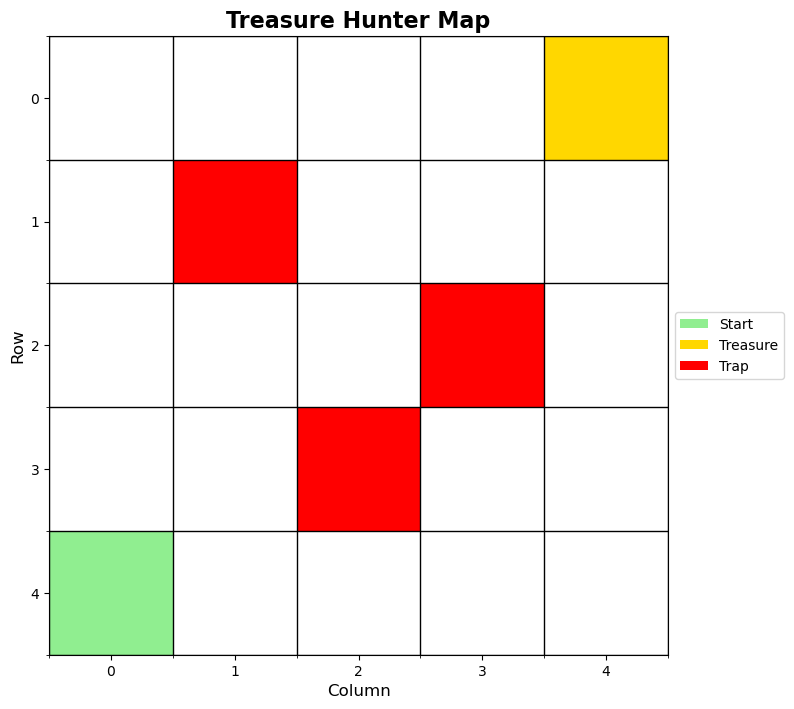

Training treasure hunter with epsilon_greedy policy...
Running 1000 episodes..

Episode 1000: Avg Reward = 62.78, Avg Steps = 11.22, ε = 0.300
   Training completed!

Let's see how our hunter learned:


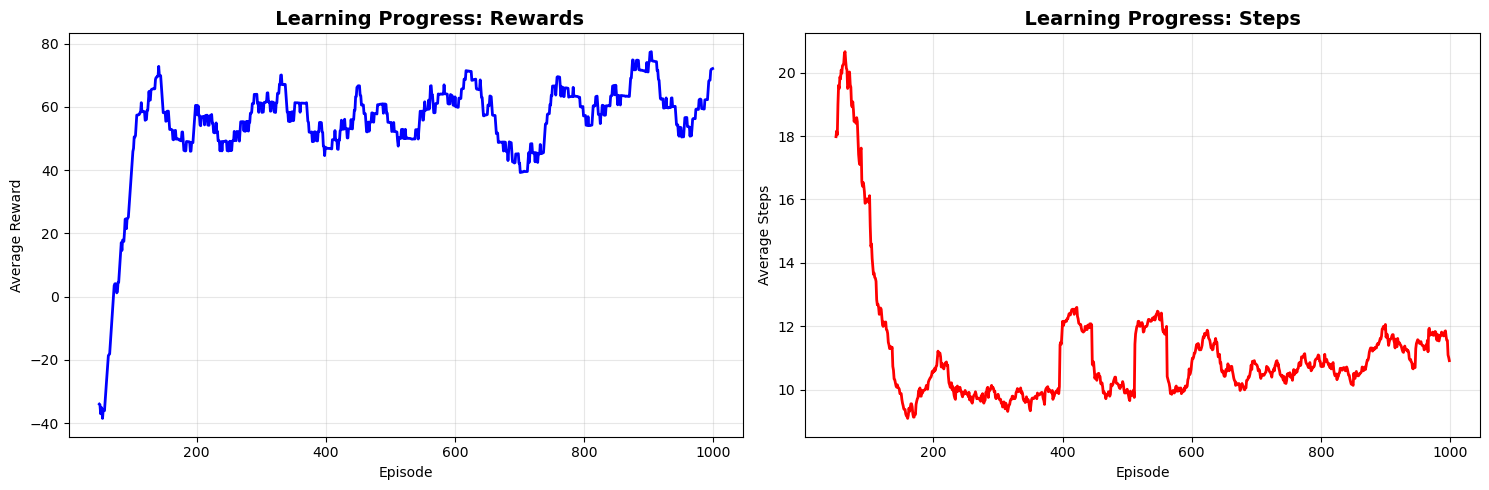


Testing our trained treasure hunter:

Testing learned policy (greedy)...
Test 1: Reward = 93, Steps = 8
Test 2: Reward = 93, Steps = 8
Test 3: Reward = 93, Steps = 8

Best path found in 8 steps with reward 93!


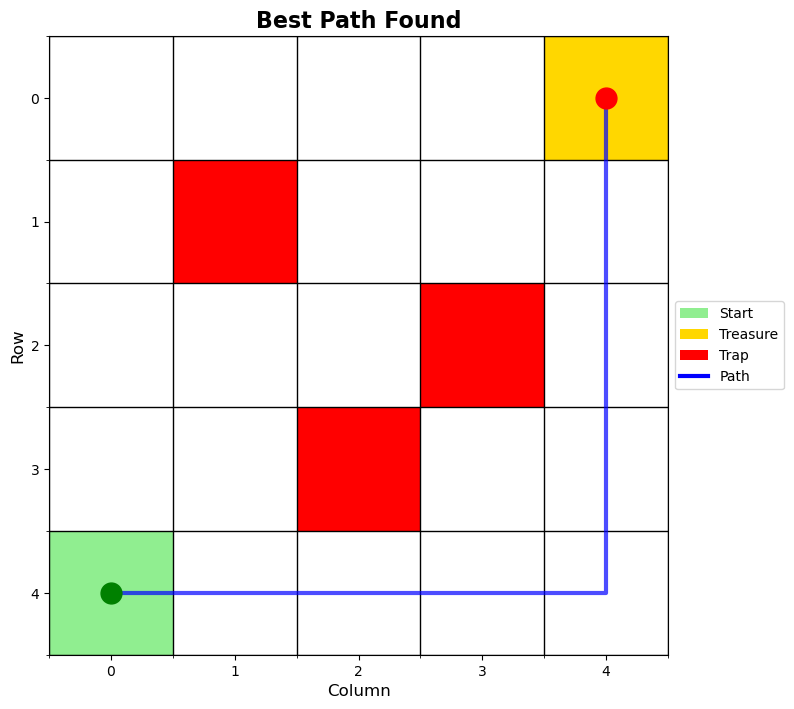


Here's what our hunter learned (Q-values):


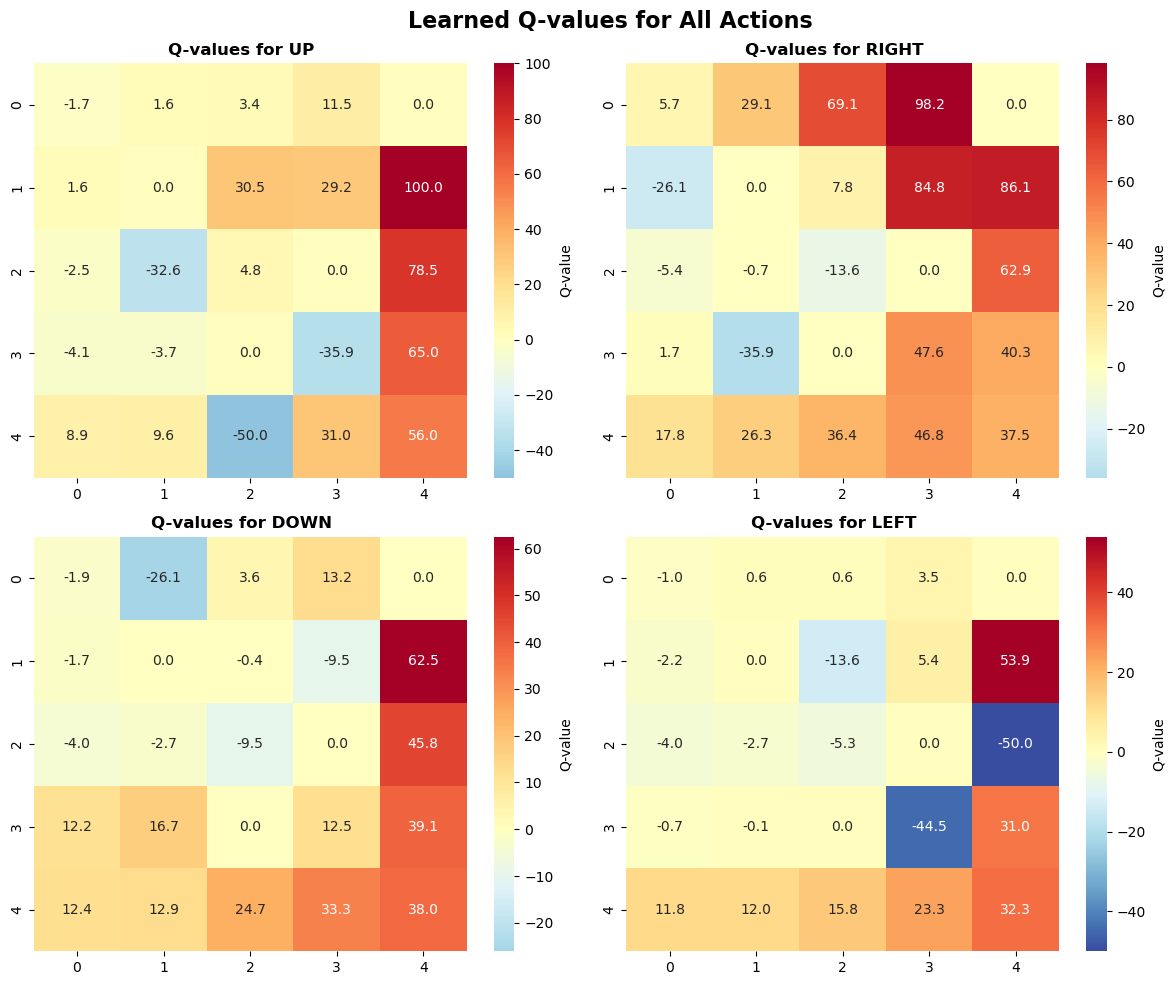



POLICY BATTLE ARENA!
Let's see which policy performs best!

POLICY COMPARISON BATTLE!

         Training with epsilon_greedy policy...
Training treasure hunter with epsilon_greedy policy...
Running 500 episodes..

   Training completed!

Testing learned policy (greedy)...
Test 1: Reward = 93, Steps = 8
Test 2: Reward = 93, Steps = 8
Test 3: Reward = 93, Steps = 8
Test 4: Reward = 93, Steps = 8
Test 5: Reward = 93, Steps = 8
Test 6: Reward = 93, Steps = 8
Test 7: Reward = 93, Steps = 8
Test 8: Reward = 93, Steps = 8
Test 9: Reward = 93, Steps = 8
Test 10: Reward = 93, Steps = 8
   epsilon_greedy: Avg Reward = 93.0 (±0.0), Success Rate = 100.0%

         Training with boltzmann policy...
Training treasure hunter with boltzmann policy...
Running 500 episodes..

   Training completed!

Testing learned policy (greedy)...
Test 1: Reward = 93, Steps = 8
Test 2: Reward = 93, Steps = 8
Test 3: Reward = 93, Steps = 8
Test 4: Reward = 93, Steps = 8
Test 5: Reward = 93, Steps = 8
Test 6: Reward 

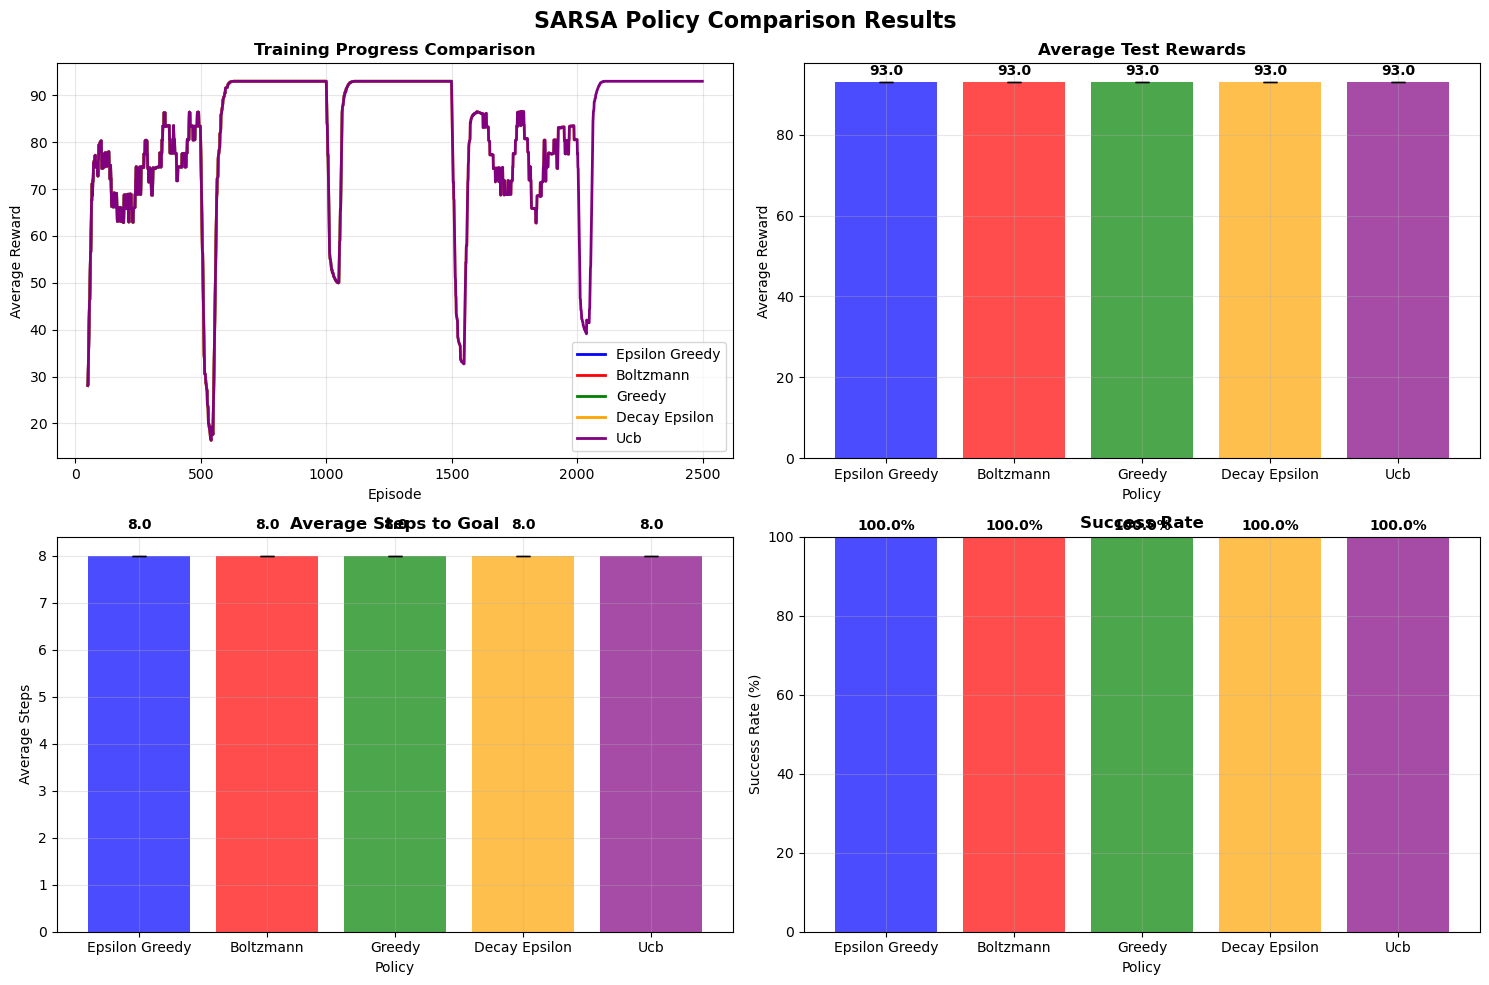

THE WINNER IS: EPSILON GREEDY!
   Success Rate: 100.0%
   Average Reward: 93.0


PARAMETER TUNING LAB!
Let's see how different parameters affect learning!

Testing different learning rates...
Training treasure hunter with epsilon_greedy policy...
Running 800 episodes..

   Training completed!


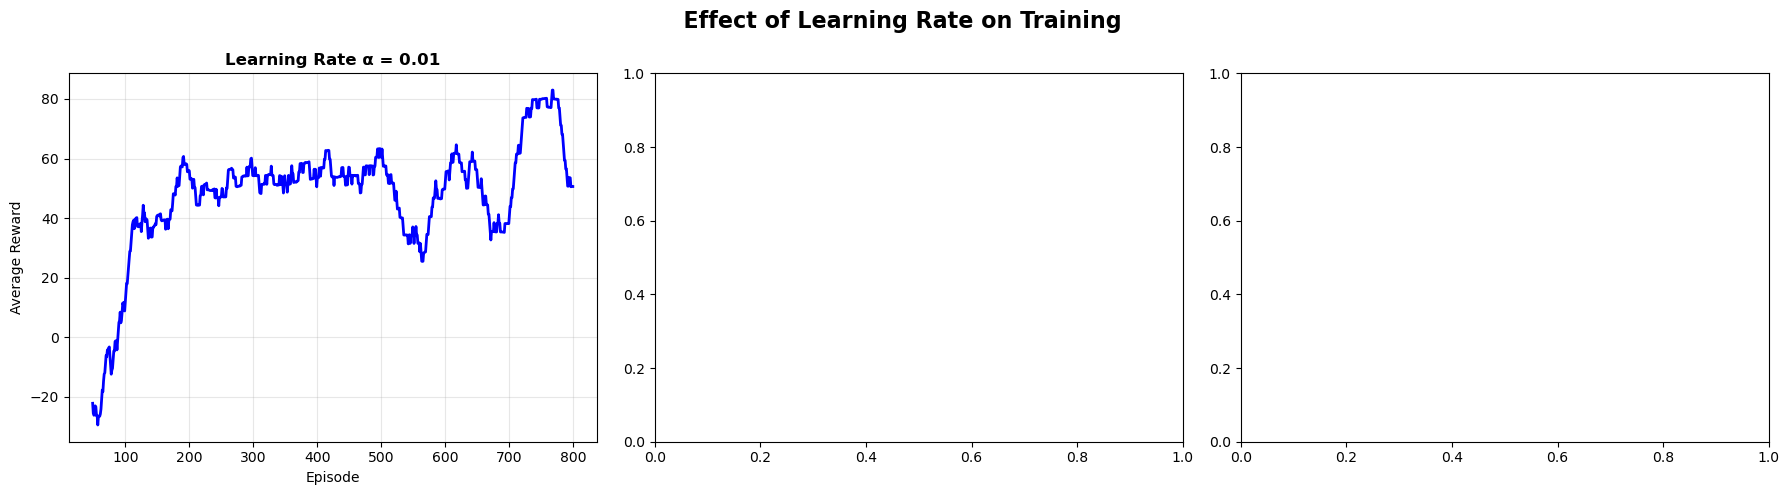

          Observations:
  • Low α (0.01): Slow but stable learning
  • Medium α (0.1): Good balance of speed and stability
  • High α (0.5): Fast but potentially unstable learning
Training treasure hunter with epsilon_greedy policy...
Running 800 episodes..

   Training completed!


<Figure size 640x480 with 0 Axes>

          Observations:
  • Low α (0.01): Slow but stable learning
  • Medium α (0.1): Good balance of speed and stability
  • High α (0.5): Fast but potentially unstable learning
Training treasure hunter with epsilon_greedy policy...
Running 800 episodes..

   Training completed!


<Figure size 640x480 with 0 Axes>

          Observations:
  • Low α (0.01): Slow but stable learning
  • Medium α (0.1): Good balance of speed and stability
  • High α (0.5): Fast but potentially unstable learning

explore SARSA!


In [9]:
# Interactive Parameter Tuning
def interactive_parameter_tuning(): 
    print("=" * 60) 
    print("PARAMETER TUNING LAB!") 
    print("=" * 60) 
    print("Let's see how different parameters affect learning!") 
    print() 
    # Test different learning rates 
    print("Testing different learning rates...") 
    alphas = [0.01, 0.1, 0.5] 
    fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 
        
    for i, alpha in enumerate(alphas): 
        agent = TreasureHunterSARSA(alpha=alpha, epsilon=0.2) 
        agent.train(episodes=800, verbose=False) 
        
        # Plot learning curve 
        window = 50 
        if len(agent.episode_rewards) > window: 
            smooth_rewards = np.convolve(agent.episode_rewards, np.ones(window)/window, 
mode='valid') 
            episodes = np.arange(window-1, len(agent.episode_rewards)) 
        else: 
            smooth_rewards = agent.episode_rewards 
            episodes = np.arange(len(agent.episode_rewards)) 
        
        axes[i].plot(episodes, smooth_rewards, 'b-', linewidth=2) 
        axes[i].set_title(f'Learning Rate α = {alpha}', fontweight='bold') 
        axes[i].set_xlabel('Episode') 
        axes[i].set_ylabel('Average Reward') 
        axes[i].grid(True, alpha=0.3) 
    
        plt.suptitle('  Effect of Learning Rate on Training', fontsize=16, fontweight='bold') 
        plt.tight_layout() 
        plt.show() 
        
        print("          Observations:") 
        print("  • Low α (0.01): Slow but stable learning") 
        print("  • Medium α (0.1): Good balance of speed and stability") 
        print("  • High α (0.5): Fast but potentially unstable learning")

#MAIN EXECUTION 
if __name__ == "__main__": 
    print("Choose your adventure:") 
    print("1.Basic SARSA Demo") 
    print("2.Policy Comparison") 
    print("3.Parameter Tuning") 
    print("4.Full Demo (All of the above!)") 
    
    choice = input("\nEnter your choice (1-4): ").strip() 
    
    if choice == '1': 
        demo_basic_sarsa() 
    elif choice == '2': 
        demo_policy_comparison() 
    elif choice == '3': 
        interactive_parameter_tuning() 
    elif choice == '4': 
        print("RUNNING FULL DEMO!\n") 
        demo_basic_sarsa() 
        print("\n" + "="*60 + "\n") 
        demo_policy_comparison() 
        print("\n" + "="*60 + "\n") 
        interactive_parameter_tuning() 
    else: 
        print("Running Basic Demo...") 
        demo_basic_sarsa() 
    print("\nexplore SARSA!") 

In [11]:
def tune_hyperparameters():
    alphas = [0.1, 0.3, 0.5]
    gammas = [0.8, 0.9, 0.99]
    decay_rates = [0.001, 0.005]
    
    episodes = 300
    trials = 5  # repeat runs for averaging
    
    results = {}
    
    for alpha in alphas:
        for gamma in gammas:
            for decay in decay_rates:
                avg_rewards = []
                for _ in range(trials):
                    agent = TreasureHunterSARSA(alpha=alpha, gamma=gamma, decay_rate=decay)
                    rewards = [agent.run_episode(policy='epsilon_greedy')[0] for _ in range(episodes)]
                    avg_rewards.append(np.mean(rewards[-50:]))  # average of last 50 episodes
                results[(alpha, gamma, decay)] = np.mean(avg_rewards)
                print(f"α={alpha}, γ={gamma}, decay={decay} → Avg Reward = {results[(alpha, gamma, decay)]:.3f}")
    
    # Best parameters
    best_params = max(results, key=results.get)
    print("\n✅ Best Hyperparameters:", best_params, "with Avg Reward =", results[best_params])
    return results, best_params

results, best = tune_hyperparameters()

α=0.1, γ=0.8, decay=0.001 → Avg Reward = 70.008
α=0.1, γ=0.8, decay=0.005 → Avg Reward = 80.464
α=0.1, γ=0.9, decay=0.001 → Avg Reward = 75.192
α=0.1, γ=0.9, decay=0.005 → Avg Reward = 76.768
α=0.1, γ=0.99, decay=0.001 → Avg Reward = 75.952
α=0.1, γ=0.99, decay=0.005 → Avg Reward = 77.400
α=0.3, γ=0.8, decay=0.001 → Avg Reward = 77.876
α=0.3, γ=0.8, decay=0.005 → Avg Reward = 83.436
α=0.3, γ=0.9, decay=0.001 → Avg Reward = 77.448
α=0.3, γ=0.9, decay=0.005 → Avg Reward = 78.244
α=0.3, γ=0.99, decay=0.001 → Avg Reward = 75.688
α=0.3, γ=0.99, decay=0.005 → Avg Reward = 75.224
α=0.5, γ=0.8, decay=0.001 → Avg Reward = 74.052
α=0.5, γ=0.8, decay=0.005 → Avg Reward = 78.888
α=0.5, γ=0.9, decay=0.001 → Avg Reward = 73.428
α=0.5, γ=0.9, decay=0.005 → Avg Reward = 75.696
α=0.5, γ=0.99, decay=0.001 → Avg Reward = 63.456
α=0.5, γ=0.99, decay=0.005 → Avg Reward = 62.380

✅ Best Hyperparameters: (0.3, 0.8, 0.005) with Avg Reward = 83.43599999999999
